# Импорт библиотек

In [2]:
import numpy as np
from gzip import open # NB: overrides standard open()
import pickle as pkl
import pandas as pd
import warnings 
from glob import glob
import os
import math
import functools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from numpy import linalg as LA
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [3]:
import matplotlib as mpl

### Отключим предупреждения Anaconda

In [4]:
warnings.simplefilter('ignore')

# Загрузим данные

In [5]:
Xdata_numpy = pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/X.pkl.gz', 'rb'))
Ydata = pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/y.pkl.gz', 'rb'))

# N-PLS1
## Приближение к правильному алгоритму
### Опишу ка я центрирование в виде класса, для удобства.

In [6]:
class centrir(BaseEstimator):
    """"Этот класс производит центрирование, а потом из центрированных данных переходит обратно"""
    def  __init__(self, testSize=2*0.02857, column_y=0):
        self.testSize = testSize
        self.column_y=column_y
    
    def centering_and_cv(self,xx,yy):
        x=xx.copy()
        y=yy.copy()
        x_centrir=np.array(x)
        y_centrir=y.iloc[:,self.column_y].to_numpy()
        x_centrir -= x_centrir.mean(axis = 0)
        #x_centrir -= x_centrir.mean()
        self.medium=y_centrir.mean() #Это сренее значение у. 
        y_centrir -= y_centrir.mean() 
        
        X_train, X_test, y_train, y_test = train_test_split(
                x_centrir, y_centrir, test_size=self.testSize 
                )
        self.X_train=X_train
        self.X_test=X_test
        self.y_train=y_train
        self.y_test=y_test
        return self
    
    def recentering(self,yy):
            y=yy.copy()
            y+=self.medium
            return y
        

In [6]:
class Tri_PLS1_grid(RegressorMixin,BaseEstimator):
    def  __init__(self, n_components=2):
        self.n_components = n_components
        
            
    def fit(self, xx, yy):
        """Fits the model to the data (X, y)

        Parameters
        ----------
        X : ndarray
        y : 1D-array of shape (n_samples, )
            labels associated with each sample"""
        x=xx.copy()
        y=yy.copy()        
        Tt=np.zeros([x.shape[0],self.n_components])
        mass=np.zeros([y.shape[0]])
        y_copy=yy.copy()
        """"
        При различных способах разрезания исходных данных, массивы w_k и w_i имеют похожие значения и именно их я планирую 
        использовать для функции predict данного класса. """
        w_k_mass=np.zeros([self.n_components,x.shape[1],1])
        w_i_mass=np.zeros([self.n_components,x.shape[2],1])
        bf_array=[]
        for f in range(0,self.n_components):
            z=np.zeros([x.shape[1],x.shape[2]])
            x_product=np.zeros([x.shape[0],x.shape[1],x.shape[2]])
            for i in range(0,x.shape[0]):
                x_product[i,:,:]=x[i,:,:]*y[i]
            z=x_product.sum(axis=0)
            Wk, S, WI = np.linalg.svd(z)
            w_k=np.array(Wk[0,:]).reshape(x.shape[1],1)
            w_i=np.array(WI[0,:]).reshape(x.shape[2],1)
            w_k_mass[f,:,:]=w_k
            w_i_mass[f,:,:]=w_i
            
            for h in range(0,x.shape[0]):
                 Tt[h,f]=np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)
            T=np.array(Tt[:,0:f+1]).reshape(x.shape[0],f+1)
            bf=np.dot(np.dot(np.linalg.inv(np.dot(T.transpose(),T)),T.transpose()),y)
            bf_array+=[bf]
            mmas=np.kron(Tt[:,f],np.kron(w_i,w_k).reshape(x.shape[1],x.shape[2])).reshape(x.shape[0],x.shape[1],x.shape[2])
            x=x-(mmas)             
            y=y-(np.dot(T,bf))
            mass+=np.dot(T,bf)   
        self.bf_array=bf_array
        self.train_error=mean_squared_error(mass,y_copy)
        self.w_k=w_k_mass
        self.w_i=w_i_mass
        
        return self
    
    
    def predict(self, xx):
        x=xx.copy()
        xn=x.reshape(x.shape[0],x.shape[1]*x.shape[2])
        wk=np.array(self.w_k[0,:,:]).reshape(x.shape[1],1)
        wj=np.array(self.w_i[0,:,:]).reshape(x.shape[2],1)
        ww=np.kron(wk,wj).reshape(xn.shape[1])
        R=np.zeros([xn.shape[1],self.n_components])
        t=np.zeros([self.n_components,x.shape[0]])
        R[:,0]=ww.reshape(xn.shape[1])
        t[0,:]=np.dot(xn.copy(),ww).reshape(x.shape[0])
        I=np.eye(xn.shape[1])
        P=np.eye(xn.shape[1])
        p=np.ones([xn.shape[1]])
        B=np.zeros([self.n_components,self.n_components])
        for j in range(0,self.n_components):
            num=0
            for i in self.bf_array[j]:
                B[j,num]=i
                num+=1
        B=np.array([B]).reshape(self.n_components,self.n_components)
        b=B.sum(axis=0)
        kp=np.zeros([xn.shape[1]])
        for f in range(0,self.n_components-1):
            w=np.zeros([xn.shape[1]])
            w=np.kron(np.array(self.w_k[f,:,:]).reshape(x.shape[1],1),
                      np.array(self.w_i[f,:,:]).reshape(x.shape[2],1)
                     ).reshape(xn.shape[1])
            w_p=np.zeros([xn.shape[1]])
            w_p=np.kron(np.array(self.w_k[f+1,:,:]).reshape(x.shape[1],1),
                        np.array(self.w_i[f+1,:,:]).reshape(x.shape[2],1)
                       ).reshape(xn.shape[1])
            if (f<0.9):
                P=I-np.kron(w,w.transpose()).reshape(xn.shape[1],xn.shape[1])
                kp=np.dot(P,w_p).reshape(xn.shape[1])
            else:
                P=I-np.kron(kp,w.transpose()).reshape(xn.shape[1],xn.shape[1])
                kp=np.dot(P,w_p).reshape(xn.shape[1])
            
            
            
            t[f+1,:]=np.dot(xn.copy(),kp.copy()).reshape(x.shape[0])
            R[:,f+1]=kp.reshape(xn.shape[1])
        
        b_pls1=np.dot(R,b).reshape(xn.shape[1])
        y=np.dot(xn,b_pls1).reshape(x.shape[0])
        self.b=b_pls1
        return y

# Класс для отбора переменных.
### Пока что он не связан с регрессионным классом, но в будущем я его доработаю.

In [7]:
class variable_class():
    def  __init__(self, number_variable_emission=7, number_variable_excitation=4):
        self.number_variable_emission=number_variable_emission
        self.number_variable_excitation=number_variable_excitation
        
    def finding_variable(self,bn_npls1):
        dict_with_collumns=dict()
        b_npls1=bn_npls1.copy()
        for i in range(b_npls1.shape[1]):
            col_max=max(np.fabs(b_npls1[:,i]))
            dict_with_collumns[col_max]=i
        column_list_tuple=sorted(dict_with_collumns.items(), reverse=True)[:self.number_variable_excitation]
        num_column_r=list()
        for maxim, number in column_list_tuple:
            num_column_r.append(number)
        num_column=sorted(num_column_r)
        b_new_columns=b_npls1[:,num_column]
        self.num_column=num_column # Номера отобранных колонок матриц начиная с 0, так как индексация range () начинается с 0 
        # теперь отберу строчки
        dict_with_rows=dict()
        for i in range(b_new_columns.shape[0]):
            row_max=max(np.fabs(b_new_columns[i,:]))
            dict_with_rows[row_max]=i
        row_list_tuple=sorted(dict_with_rows.items(), reverse=True)[:self.number_variable_emission]
        num_row_r=list()
        for maxim,number in row_list_tuple:
            num_row_r.append(number)
        num_row=sorted(num_row_r)
        self.num_row=num_row  # Номера отобранных строчек
        b_new=b_new_columns[num_row,:]
        self.b_new=b_new
        return self
    
    def transform(self,xn):
        #На вход подавать тензор
        x=xn.copy()
        x_new=np.zeros([x.shape[0],len(self.num_row),len(self.num_column)])
        for matrixx in range(x.shape[0]):
            len_x_new=0
            for i in self.num_column:
                shape_x_new=0
                for j in self.num_row:
                    x_new[matrixx,shape_x_new,len_x_new]=x[matrixx,j,i]
                    shape_x_new+=1
                len_x_new+=1
        return x_new
    
    def emission_vave_lenth(self,emissions_array):
        emission=emissions_array.copy()
        emission_new=np.zeros([len(self.num_row)])
        for i in range(len(self.num_row)):
            emission_new[i]=emission[self.num_row[i]]
        return emission_new
    
    def excitation_vave_lenth(self, excitation_array):
        excitation=excitation_array.copy()
        excitation_new=np.zeros([len(self.num_column)])
        for i in range(len(self.num_column)):
            excitation_new[i]=excitation[self.num_column[i]]
        return excitation_new

# Центрируем данные (замена: вместо 3-х методов теперь 2)

In [8]:
cen=centrir(testSize=0.1428,column_y=0)

In [9]:
result=cen.centering_and_cv(Xdata_numpy['X'],Ydata)

In [10]:
y_train=result.y_train
y_test=result.y_test
X_train=result.X_train
X_test=result.X_test

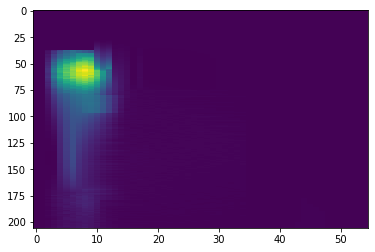

In [11]:
plt.imshow(X_train[5,:,:],aspect='auto')
plt.show()

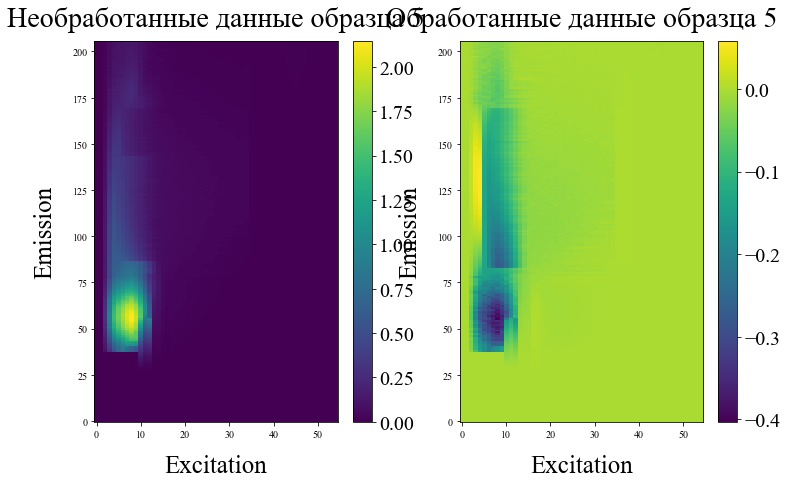

In [34]:
import matplotlib as mpl
mpl.rc('font',family='Times New Roman')
plt.figure(figsize=(12,7))

plt.subplot(1,2,1)
plt.imshow(Xdata_numpy['X'][4,:,:],aspect="auto", origin='lower')
plt.ylabel("Emission" , fontsize=25,labelpad=15)
plt.xlabel("Excitation",  fontsize=25,labelpad=15)
plt.title("Необработанные данные образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
#plt.yticks(indexi,high,fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

plt.subplot(1,2,2)
plt.imshow(X_train[4,:,:],aspect="auto", origin='lower')
plt.ylabel("Emission" , fontsize=25,labelpad=15)
plt.xlabel("Excitation",  fontsize=25,labelpad=15)
plt.title("Обработанные данные образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
#plt.yticks(indexi,high,fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

#plt.savefig('Центрированные данные данные образца 5.png', format='png', dpi=300)
plt.show();

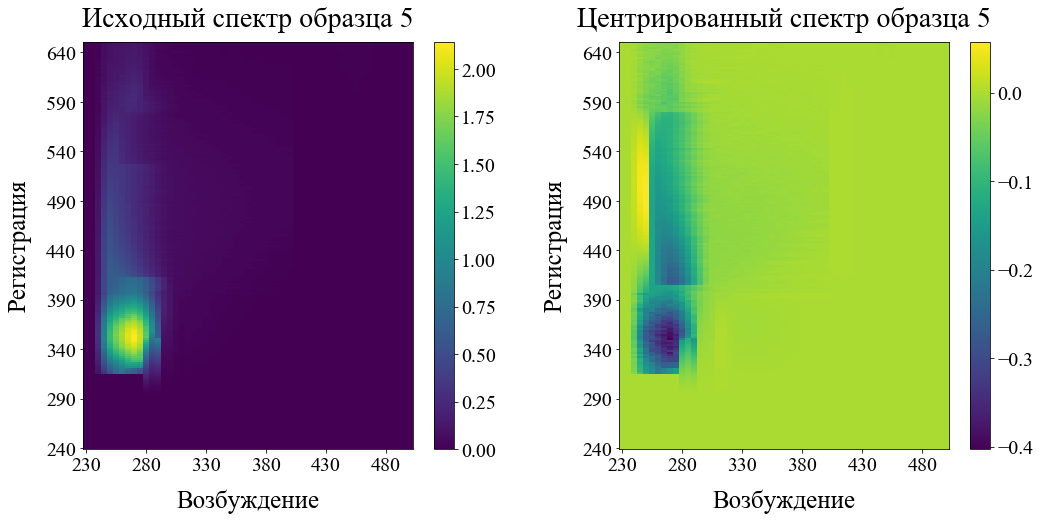

In [75]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(17, 7.5),constrained_layout=False)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0.3, hspace=0)

fig_ax_1 = fg.add_subplot(gs[0, 0])
plt.imshow(Xdata_numpy['X'][4,:,:],aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Исходный спектр образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
#plt.yticks(range(240,690,50),fontsize=20)
fig_ax_1.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_1.set_xticklabels(range(180,520,50), fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

fig_ax_2 = fg.add_subplot(gs[0, 1])
plt.imshow(X_train[4,:,:],aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Центрированный спектр образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
fig_ax_2.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_2.set_xticklabels(range(180,520,50), fontsize=20)
#plt.yticks(indexi,high,fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

plt.savefig('centering.png', format='png', dpi=300)
plt.savefig("centering.svg", format="svg")

plt.show();

In [65]:
?plt.title

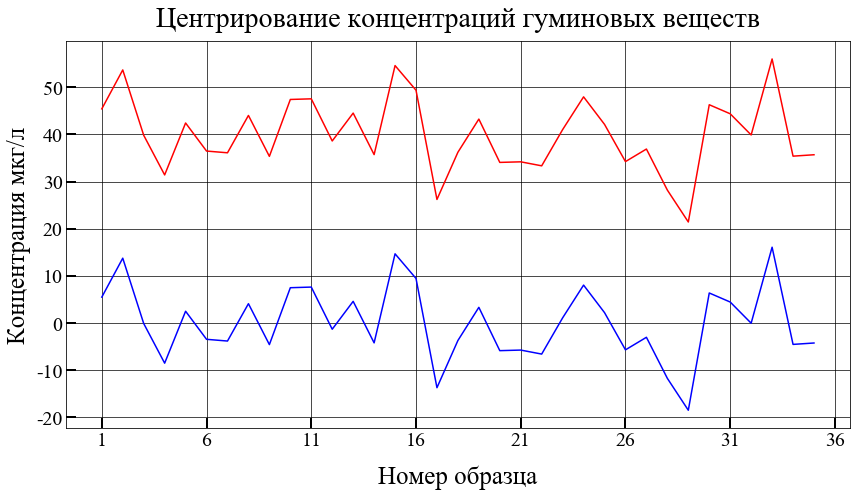

In [83]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(Ydata.iloc[:,0],"-",color="red",ms=20)
axs.plot(Ydata.iloc[:,0].to_numpy()-Ydata.iloc[:,0].to_numpy().mean(),"-",color="blue",ms=20)


#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))

axs.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
axs.grid(color="black", drawstyle="default", linewidth=0.7)
axs.set_xlabel("Номер образца",  fontsize=25,labelpad=15)
axs.set_title("Центрирование концентраций гуминовых веществ", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

axs.set_xticklabels(range(-4,42,5), fontsize=20)
axs.set_yticklabels(range(-30,60,10), fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
#axs.legend(loc=4,fontsize=20, markerscale=1,handletextpad=0)

#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран
fig.tight_layout()
#fig.set_figwidth(12) можно задать размеры самого поля для рисования
#fig.set_figheight(6)

plt.savefig('Центрирование концентраций гуминовых веществ.png', format='png', dpi=300)
plt.savefig("Центрирование концентраций гуминовых веществ.svg", format="svg")


plt.show();

In [769]:
y_test=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'rb'))['y_test']
y_train=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'rb'))['y_train']
X_train=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'rb'))['X_train']
X_test=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'rb'))['X_test']

# Делаем применение сразу по всем компонентам

In [770]:
npls1=Tri_PLS1_grid()
parametrsNames={'n_components': [3]}

In [771]:
%%time
gridCought=GridSearchCV(npls1, parametrsNames, cv=5,return_train_score=True)
gridCought.fit(X_train.copy(),y_train.copy())
r2_p=gridCought.score(X_test.copy(), y_test.copy())
r2_cv=gridCought.cv_results_[ "mean_test_score" ]
r2_c=gridCought.cv_results_[ "mean_train_score" ]
predictors=gridCought.predict(X_test.copy())

Wall time: 2min 27s


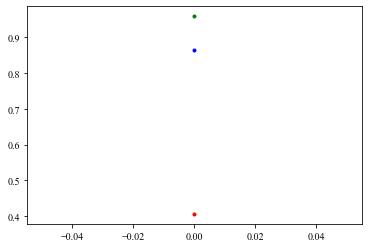

In [772]:
plt.plot(r2_p,".",color='green')
plt.plot(r2_c,".",color='blue')
plt.plot(r2_cv,".",color='red')
plt.show()

In [773]:
b_npls1_full=gridCought.best_estimator_.b.reshape(206,55)

### Определю ка я число волн emission в цикле, а то 7 плохо на Гуминах работает

In [803]:
new_r2_p=list()
new_r2_cv=list()
new_r2_c=list()
nmt=list()

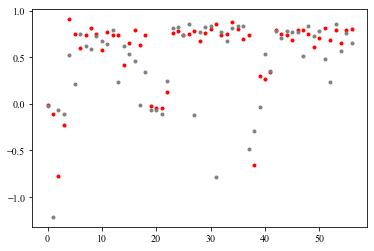

In [815]:
new_r2_p=list()
new_r2_cv=list()
new_r2_c=list()
nmt=list()
for j in range(2,5):
    for i in range(2,21):
        select=variable_class(number_variable_emission=i, number_variable_excitation=j)
        select.finding_variable(b_npls1_full)
        x_new=select.transform(Xdata_numpy['X'])
        new_cen=centrir(testSize=0.1428,column_y=2)
        new_result=new_cen.centering_and_cv(x_new,Ydata)
        y_train=new_result.y_train
        y_test=new_result.y_test
        X_train=new_result.X_train
        X_test=new_result.X_test
        new_npls1=Tri_PLS1_grid()
        parametrsNames={'n_components': range(1,8)}
        new_gridCought=GridSearchCV(new_npls1, parametrsNames, cv=5,return_train_score=True)
        new_gridCought.fit(X_train.copy(),y_train.copy())
        new_r2_p+=[new_gridCought.score(X_test.copy(), y_test.copy())]
        new_r2_cv+=[max(new_gridCought.cv_results_[ "mean_test_score" ])]
        new_r2_c+=[max(new_gridCought.cv_results_[ "mean_train_score" ])]
        nmt+=[0.5*(new_gridCought.score(X_test.copy(), y_test.copy())+max(new_gridCought.cv_results_[ "mean_test_score" ]))]
plt.plot(new_r2_cv,".", color="red")
plt.plot(nmt,".", color="grey")
plt.show()

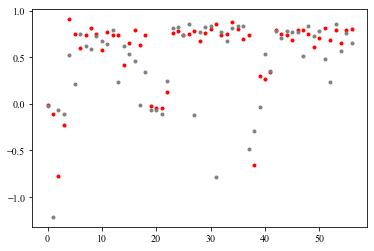

In [816]:
#plt.plot(new_r2_p,".", color="green")
#plt.plot(new_r2_c, ".", color="blue")
plt.plot(new_r2_cv,".", color="red")
plt.plot(nmt,".", color="grey")
plt.show()

In [817]:
max(nmt)

0.8555678761837362

In [818]:
max(new_r2_cv)

0.9080603594930906

In [819]:
mma=nmt

In [820]:
n_r2_cv_prr=new_r2_cv

In [142]:
len(n_r2_cv_prr)/3

19.0

In [58]:
print(new_r2_cv[13],new_r2_p[13])

-0.1840198700832275 -0.2156442228061255


In [49]:
14 0.42726841144390604

14

In [50]:
r2_cv_pr=new_r2_cv
r2_p_pr=new_r2_p

In [59]:
print(r2_cv_pr[13],r2_p_pr[13])

0.42726841144390604 0.07090149193088291


#### Построю ка график в зависимости от число длин волн r2

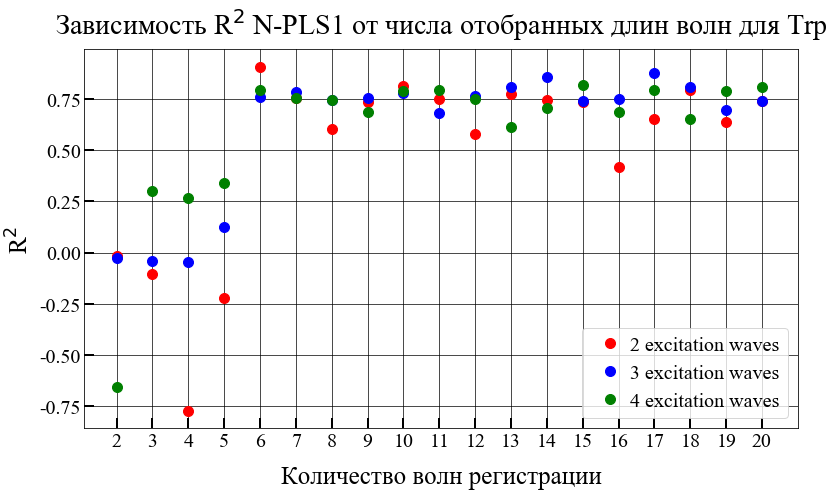

In [823]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(n_r2_cv_prr[:19],".",color="red",ms=20,label='2 excitation waves')
axs.plot(n_r2_cv_prr[19:38],".",color="blue",ms=20,label='3 excitation waves')
axs.plot(n_r2_cv_prr[38:57],".",color="green",ms=20,label='4 excitation waves')

axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))

axs.set_ylabel('R$^{2}$',  fontsize=25,labelpad=5)
axs.grid(color="black", drawstyle="default", linewidth=0.7)
axs.set_xlabel("Количество волн регистрации",  fontsize=25,labelpad=15)
axs.set_title("Зависимость R$^{2}$ N-PLS1 от числа отобранных длин волн для Trp", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

axs.set_xticklabels(range(2,21,1), fontsize=20)
axs.set_yticklabels(['0','-0.75','-0.50','-0.25','0.00','0.25',
                     '0.50','0.75','0.20','0.30','0.40','0.50','0.60','0.70'], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
axs.legend(loc=4,fontsize=20, markerscale=1,handletextpad=0)

axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран
fig.tight_layout()
#fig.set_figwidth(12) можно задать размеры самого поля для рисования
#fig.set_figheight(6)

plt.savefig('N-PLS1 Tyr с использованием числа отобранных длин волн для Trp.png', format='png', dpi=300)
plt.savefig("N-PLS1 Tyr с использованием числа отобранных длин волн для Trp.svg", format="svg")


plt.show();

##### Для Гуминов мне приглянулись 2 точки: 2 excit. 9 emission and 4 excit. 16 emiss.

In [645]:
mma[7]

-1.44546081556455

In [646]:
mma[13]

-0.21164932246441437

In [824]:
pkl.dump(
	{'r2_cv': n_r2_cv_prr, 'r2_p': mma},
	open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final_number_wave_emission_excitation.pkl.gz', 'wb')
)

### Теперь произведём отбор переменных из исходных данных, чтобы потом заново центрировать и обучить новую модель

In [929]:
select=variable_class(number_variable_emission=7, number_variable_excitation=3)
select.finding_variable(b_npls1_full)

In [930]:
x_new=select.transform(Xdata_numpy['X'])

### Заново центрируем новые данные

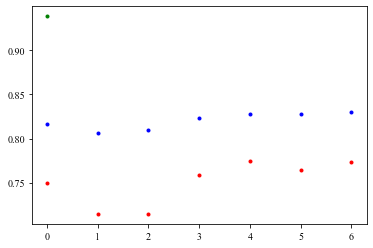

In [931]:
new_r2_cv=[0,0]
new_cen=centrir(testSize=0.1428,column_y=2)
new_result=new_cen.centering_and_cv(x_new,Ydata)
y_train=new_result.y_train
y_test=new_result.y_test
X_train=new_result.X_train
X_test=new_result.X_test
new_npls1=Tri_PLS1_grid()
parametrsNames={'n_components': range(1,8)}
new_gridCought=GridSearchCV(new_npls1, parametrsNames, cv=5,return_train_score=True)
new_gridCought.fit(X_train.copy(),y_train.copy())
new_r2_p=new_gridCought.score(X_test.copy(), y_test.copy())
new_r2_cv=new_gridCought.cv_results_[ "mean_test_score" ]
new_r2_c=new_gridCought.cv_results_[ "mean_train_score" ]
new_predictors=new_gridCought.predict(X_test.copy())
plt.plot(new_r2_p,".", color="green")
plt.plot(new_r2_c, ".", color="blue")
plt.plot(new_r2_cv,".", color="red")
plt.show()

In [932]:
new_r2_p

0.9386911702249452

In [290]:
new_result=new_cen.centering_and_cv(x_new,Ydata)

In [291]:
y_train=new_result.y_train
y_test=new_result.y_test
X_train=new_result.X_train
X_test=new_result.X_test

### Снова делаем обучение по всем компонентам, но уже на новых данных

In [292]:
new_npls1=Tri_PLS1_grid()
parametrsNames={'n_components': range(1,8)}

In [293]:
%%time
new_gridCought=GridSearchCV(new_npls1, parametrsNames, cv=5,return_train_score=True)
new_gridCought.fit(X_train.copy(),y_train.copy())
new_r2_p=new_gridCought.score(X_test.copy(), y_test.copy())
new_r2_cv=new_gridCought.cv_results_[ "mean_test_score" ]
new_r2_c=new_gridCought.cv_results_[ "mean_train_score" ]
new_predictors=new_gridCought.predict(X_test.copy())

Wall time: 214 ms


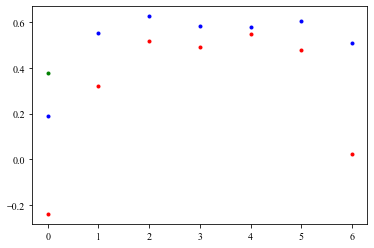

In [529]:
plt.plot(new_r2_p,".", color="green")
plt.plot(new_r2_c, ".", color="blue")
plt.plot(new_r2_cv,".", color="red")
plt.show()

In [933]:
b_npls1_small=new_gridCought.best_estimator_.b.reshape(7,3)

In [934]:
b_npls1_small

array([[ 1.18793675,  1.43212358,  0.56367563],
       [-0.22889696, -0.37208574, -0.71624092],
       [-0.1771388 , -0.32420899, -0.16310932],
       [-0.22723987, -0.0176538 , -0.49612528],
       [-0.38626498,  0.41808796,  0.30527622],
       [-0.54427213,  0.19810908, -0.02808255],
       [-0.43224991,  0.48546586, -0.08742599]])

In [935]:
new_gridCought.best_estimator_

Tri_PLS1_grid(n_components=5)

In [936]:
select.emission_vave_lenth(Xdata_numpy['emission'])

array([376., 466., 474., 492., 504., 570., 632.])

In [937]:
select.excitation_vave_lenth(Xdata_numpy['excitation'])

array([260., 265., 270.])

In [535]:
[318., 354., 362., 370., 378., 452., 458., 474., 488.]

[318.0, 354.0, 362.0, 370.0, 378.0, 452.0, 458.0, 474.0, 488.0]

In [536]:
[250., 255.]

[250.0, 255.0]

In [948]:
pkl.dump(
	{'r2_cv': new_r2_cv, 'r2_c': new_r2_c, 'r2_p': new_r2_p, 'predict':new_predictors,'y_test':y_test,
     'parametrs':gridCought.best_params_, 'True_predictors':n_predictors, 'True_y':yTest,
     'X_test':X_test,'X_train':X_train,'y_train':y_train, 'b_npls1_v-s':b_npls1_small, 
     'emission_vale_lendth':select.emission_vave_lenth(Xdata_numpy['emission']),
     'excitation_vale_lendth':select.excitation_vave_lenth(Xdata_numpy['excitation']),
     'b_npls1_without_v-s':b_npls1_full},
	open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final_with_variable_selection_7_3.pkl.gz', 'wb')
)

In [203]:
r=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Gominy_N-PLS1_final_with_variable_selection_14_2.pkl.gz', 'rb'))['excitation_vale_lendth']

In [204]:
max(r)

255.0

In [205]:
r

array([250., 255.])

In [155]:
r

array([318., 350., 352., 358., 362., 364., 366., 378., 462.])

In [87]:
b_npls1_full_humic=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Gominy_N-PLS1_final_with_variable_selection_14_2.pkl.gz', 'rb'))['b_npls1_without_v-s']
b_npls1_full_Tyr=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Tyr_N-PLS1_final_with_variable_selection_9_2.pkl.gz', 'rb'))['b_npls1_without_v-s']
b_npls1_full_Trp=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final_with_variable_selection_6_2.pkl.gz', 'rb'))['b_npls1_without_v-s']

In [88]:
b_npls1_full_humic

array([[ 5.94974443e-05, -9.39291459e-06, -5.33079404e-03, ...,
        -2.29473635e-05,  5.86624633e-05, -2.32035859e-05],
       [ 1.12405272e-04, -1.77441548e-05, -6.72535274e-03, ...,
        -4.30682286e-05,  1.10819486e-04, -4.38339840e-05],
       [-5.53331567e-04,  8.73489288e-05,  3.48308487e-02, ...,
         2.12156585e-04, -5.45529581e-04,  2.15780958e-04],
       ...,
       [-1.47364841e-04,  2.33262946e-05,  1.64301105e-01, ...,
         6.97059895e-05, -1.45671637e-04,  5.76195435e-05],
       [ 4.77280034e-03, -7.53490193e-04, -4.37298719e-01, ...,
        -1.84162847e-03,  4.70584335e-03, -1.86136814e-03],
       [ 2.25272949e-03, -3.55671943e-04, -2.79082255e-01, ...,
        -8.75426537e-04,  2.22130657e-03, -8.78624507e-04]])

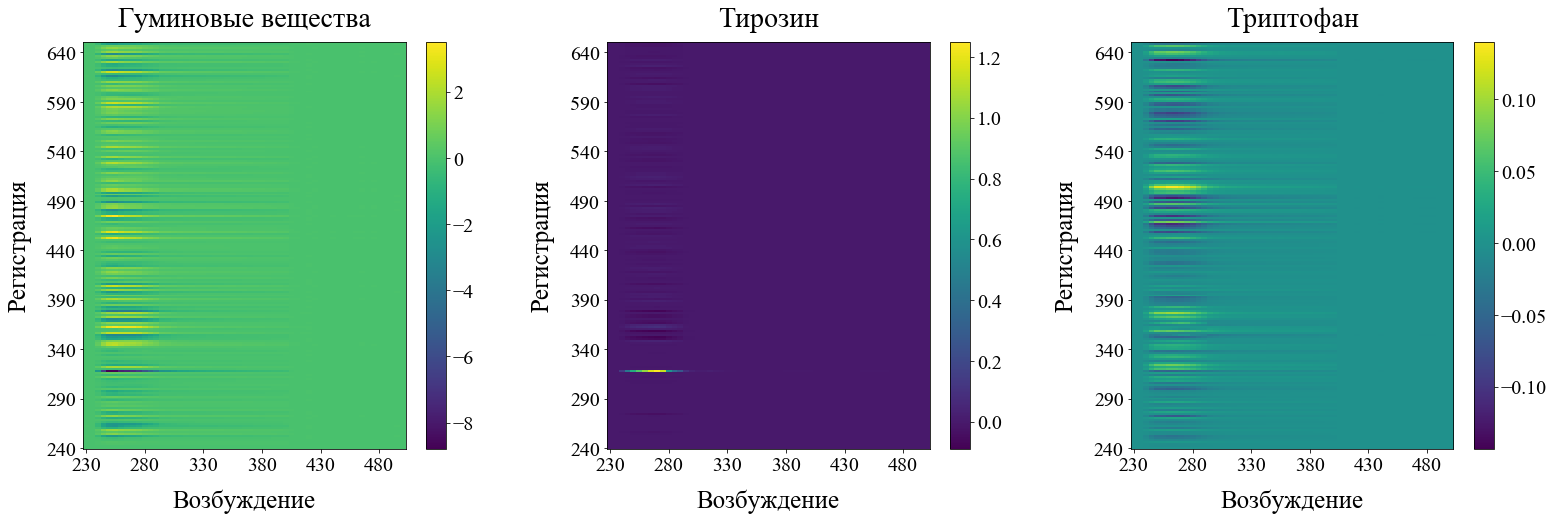

In [95]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(26, 7.5),constrained_layout=False)
gs = gridspec.GridSpec(ncols=3, nrows=1, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0.3, hspace=0.4)

fig_ax_1 = fg.add_subplot(gs[0])
plt.imshow(b_npls1_full_humic,aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Гуминовые вещества",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
#plt.yticks(range(240,690,50),fontsize=20)
fig_ax_1.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_1.set_xticklabels(range(180,520,50), fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

fig_ax_2 = fg.add_subplot(gs[1])
plt.imshow(b_npls1_full_Tyr,aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Тирозин",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
fig_ax_2.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_2.set_xticklabels(range(180,520,50), fontsize=20)
#plt.yticks(indexi,high,fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

fig_ax_3 = fg.add_subplot(gs[2])
plt.imshow(b_npls1_full_Trp,aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Триптофан",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
fig_ax_3.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_3.set_xticklabels(range(180,520,50), fontsize=20)
#plt.yticks(indexi,high,fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

plt.savefig('Регрессионные коэффициенты.png', format='png', dpi=300)
plt.savefig("Регрессионные коэффициенты.svg", format="svg")

plt.show();

# Строю R2 по новому

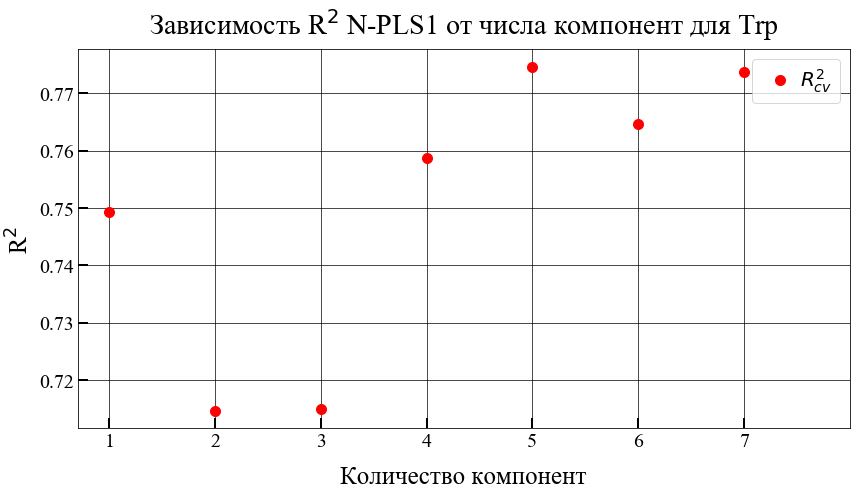

In [940]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(new_r2_cv,".",color="red",ms=20,label='$R_{cv}^{2}$')
#axs.plot(r2_c,".",color="blue",ms=20,label='$R_c^{2}$')
#axs.plot(r2_p,".",color="green",ms=20,label='$R_p^{2}$')

axs.set_xticks(range(0,7,1)) # Задаём места, где будет сетка и метки по оси ох
axs.set_yticks(np.linspace(0.72, 0.77, num = 6))

axs.set_ylabel('R$^{2}$',  fontsize=25,labelpad=5)
axs.grid(color="black", drawstyle="default", linewidth=0.7)
axs.set_xlabel("Количество компонент",  fontsize=25,labelpad=15)
axs.set_title("Зависимость R$^{2}$ N-PLS1 от числа компонент для Trp", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

axs.set_xticklabels(range(1,9,1), fontsize=20)
axs.set_yticklabels(['0.72','0.73','0.74','0.75','0.76','0.77','0.70','0.75','0.70'], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
axs.legend(loc=1,fontsize=20, markerscale=1,handletextpad=0)

axs.set_xlim(xmax=7) # можно определить границы графика которые будут выводиться на экран
fig.tight_layout()
#fig.set_figwidth(12) можно задать размеры самого поля для рисования
#fig.set_figheight(6)

plt.savefig('N-PLS1 Trp с использованием отбора переменных 7 на 3.png', format='png', dpi=300)
plt.savefig("N-PLS1 Trp с использованием отбора переменных 7 на 3.svg", format="svg")


plt.show();

# Строю введено-найдено по новому

In [941]:
yTest=y_test+new_result.medium

In [942]:
y_test

array([ 1.50618408,  0.99908813,  0.76167283, -1.49703176, -0.84637806])

In [943]:
yTest

array([4.01152098, 3.50442503, 3.26700972, 1.00830513, 1.65895884])

In [944]:
n_predictors=new_predictors+new_result.medium

In [945]:
n_predictors

array([3.67719612, 3.15592976, 3.02623163, 0.696562  , 1.79434695])

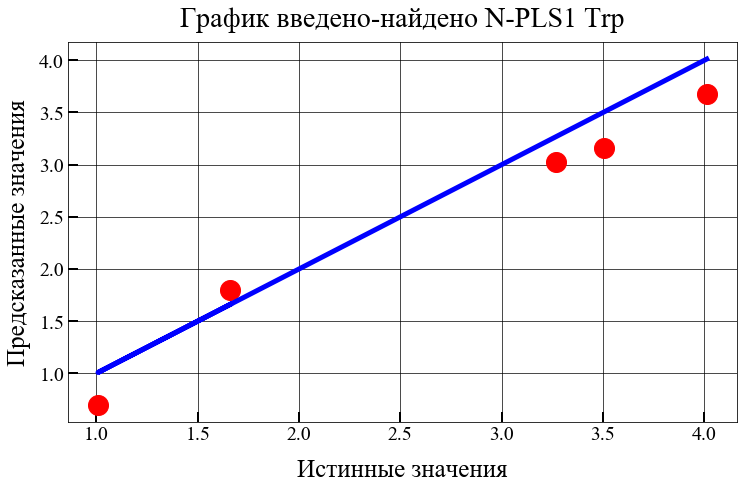

In [947]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(yTest,n_predictors,".",color="red",ms=40)
axs.plot(yTest,yTest,color="blue",lw=5)
#axs.set_yticks(np.linspace(1.0, 4.5, num = 8))
axs.set_ylabel("Предсказанные значения" , fontsize=25,labelpad=8)
axs.grid(color="black",linewidth=0.7)
axs.set_xlabel("Истинные значения",  fontsize=25,labelpad=15)
axs.set_title("График введено-найдено N-PLS1 Trp", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
axs.set_xticklabels(['0','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','50'], fontsize=20)
axs.set_yticklabels(['0','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','50'], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
plt.savefig('График введено-найдено N-PLS1 Trp с использованием отбора переменных 7 на 3.png', format='png', dpi=300)
plt.savefig("График введено-найдено N-PLS1 Trp с использованием отбора переменных 7 на 3.svg", format="svg")
plt.show();

# Сохраним абсолютно всё в пикль, потому что считать заново - это очень долго.

In [141]:
pkl.dump(
	{'r2_cv': r2_cv, 'r2_c': r2_c, 'r2_p': r2_p, 'predict':predictors,'y_test':y_test,
     'parametrs':gridCought.best_params_, 'True_predictors':n_predictors, 'True_y':yTest,
     'X_test':X_test,'X_train':X_train,'y_train':y_train},
	open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'wb')
)

### Зделаю ка я применение двух предыдущих классов тоже в виде класса

In [327]:
class run_class(RegressorMixin,BaseEstimator):
    def  __init__(self, testSize=0.1428, column_y=0, components_array=range(1,17), number_vallidations=5):
        self.testSize = testSize
        self.column_y=column_y
        self.components_array = components_array
        self.number_vallidations=number_vallidations
        
    def data_centerng(self,x,y):
        data=centrir(testSize=self.testSize, column_y=self.column_y)
        self.data_cv=data.centering_and_cv(x.copy(),y.copy())
        return self
    
    def cv(self):
        train_error=np.zeros([len(self.components_array)])
        test_error=np.zeros([len(self.components_array)])
        p_error=np.zeros([len(self.components_array)])
        n=0
        for i in self.components_array:
            regressioModel=Tri_PLS1_grid()
            parametrsNames={ 
                'n_components': [i]
            }

            gridCought=GridSearchCV(regressioModel, parametrsNames, cv=self.number_vallidations, return_train_score=True)
            gridCought.fit(self.data_cv.X_train.copy(),self.data_cv.y_train.copy())
            train_error[n]=gridCought.cv_results_[ "mean_train_score"]
            test_error[n]=gridCought.cv_results_[ "mean_test_score" ]
            
            p_error[n]=gridCought.score(self.data_cv.X_test.copy(),self.data_cv.y_test.copy())
            n+=1
        self.train_error=train_error
        self.test_error=test_error
        self.p_error=p_error
        plt.plot(train_error,".", color="red")
        plt.plot(test_error,".", color="blue")
        plt.plot(p_error,".", color="green")
        plt.show();
        return self

In [328]:
mod=run_class(testSize=0.1428,components_array=range(1,13),number_vallidations=5)

In [329]:
#mod.data_centerng(Xdata_numpy["X"][:,160:200,0:15],Ydata)

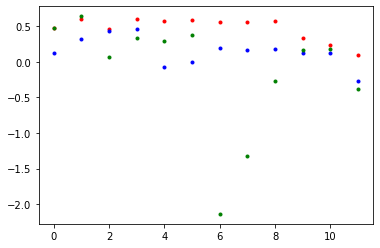

Wall time: 21.6 s


In [330]:
%%time
mod.data_centerng(Xdata_numpy["X"][:,150:200,0:20],Ydata)
result=mod.cv()

In [331]:
result

run_class(column_y=0, components_array=range(1, 13), number_vallidations=5,
          testSize=0.1428)

In [332]:
result.train_error

array([0.46931723, 0.60565466, 0.4612    , 0.60484968, 0.57221136,
       0.58184412, 0.56203913, 0.55663922, 0.56657806, 0.33714295,
       0.23930075, 0.09730211])

In [ ]:
# Пример из интернета, почитаю на досуге
def pls_variable_selection(X, y, max_comp):  
    # Define MSE array to be populated 
    mse = np.zeros((max_comp,X.shape[1])) 
    # Loop over the number of PLS components 
    for i in range(max_comp): 
        # Regression with specified number of components, using full spectrum 
        pls1 = PLSRegression(n_components=i+1) 
        pls1.fit(X, y) 
        # Indices of sort spectra according to ascending absolute value of PLS coefficients 
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0])) 
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind] 
        # Discard one wavelength at a time of the sorted spectra, 
        # regress, and calculate the MSE cross-validation 
        for j in range(Xc.shape[1]-(i+1)): 
            pls2 = PLSRegression(n_components=i+1) 
            pls2.fit(Xc[:, j:], y) 
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5) 
            mse[i,j] = mean_squared_error(y, y_cv) 
            comp = 100*(i+1)/(max_comp) 
            stdout.write("\r%d%% completed" % comp) 
            stdout.flush() 
            stdout.write("\n") 
            # # Calculate and print the position of minimum in MSE 
            mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)])) 
            print("Optimised number of PLS components: ", mseminx[0]+1) 
            print("Wavelengths to be discarded ",mseminy[0]) 
            print('Optimised MSEP ', mse[mseminx,mseminy][0]) 
            stdout.write("\n") 
            # plt.imshow(mse, interpolation=None) 
    # plt.show() # Calculate PLS with optimal components and export values 
    pls = PLSRegression(n_components=mseminx[0]+1) 
    pls.fit(X, y) sorted_ind = np.argsort(np.abs(pls.coef_[:,0])) 
    Xc = X[:,sorted_ind] 
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)